# Discrete Quantum Walks

>In a discrete quantum walk, the motion occurs on a graph, where the vertices represent the positions where the walker may step, and the edges indicate the possible directions the walker can choose to move. While space is discrete, time can be either discrete or continuous. In the discrete-time case, the walker repeatedly steps from one vertex to the next.
>To define the actions of the quantum walker, we only need to implement two operations, one is choosing all the edges that are connected to the current node, and the second one is the actual step in those directions. The operations are described mathematically as follows:
>\begin{equation} C \coloneqq \sum_{j \in V} |j \rangle \langle j | \otimes \left( 2 | \delta_j \rangle \langle \delta_j | - I \right) \end{equation}
>\begin{equation} S \coloneqq \sum_{\left(j,k\right) \in E} |j, k \rangle \langle k, j | \end{equation}
>where:
>\begin{equation} | \delta_j \rangle \coloneqq \frac{1}{\sqrt{deg\left(j\right)}}\sum_{k:\left(j,k\right) \in E} |k \rangle\end{equation}
>The C operator is generally referred as the "quantum coin" and the S operator is the swap between the two vertices (the one left by the walker and the current vertex). One step of the quantum walk is described by the unitary operator $SC$. In the following sections we will describe how each of them are implemented for two different graphs, highlighting the general parts and the specific ones for each approach.


## Implementation using Classiq
### Circular graph with 4 node

In [2]:
from classiq import *
import networkx as nx
import matplotlib.pyplot as plt

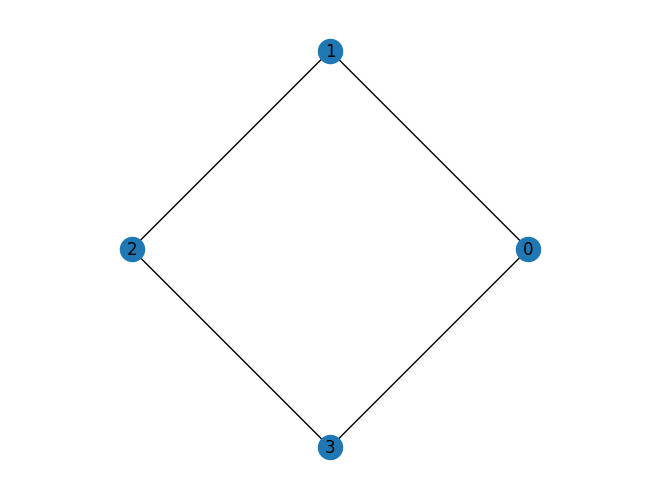

In [8]:
size = 2

edge_list = [(i, (i+1)%(2**size)) for i in range(2**size)]

G = nx.Graph(edge_list)

nx.draw_circular(G, with_labels=True)
plt.axis('equal')
plt.show()

>The graph above has all the even vertices connected with all the odd ones. This aspect will help us within this particular example to define the specific operations.
>We shall describe how each of the operators acts on the quantum states and how the specific information that describes the graph is encoded into this states.
>Firstly, the $C$ operator can be decomposed into smaller operations:
>\begin{equation} C \coloneqq \sum_{j \in V} \textcolor{violet}{ |j \rangle \langle j |} \otimes \left( \textcolor{purple}{ 2 | \delta_j \rangle \langle \delta_j | - I }\right) \end{equation}
>The $\textcolor{violet}{violet}$ part represent a control operation, where the control qubits are one vertice's index and the controlled qubits are the adjacent vertices, and the $\textcolor{purple}{purple}$ part is a Grover diffusion operator over the neighbors of the control node.
>The $\textcolor{purple}{Grover~diffusion}$ will use some  $\textcolor{#D7F75B}{Classiq}$ builtin primitives like $within\_apply$ and $inplace\_prepare\_state$.


In [11]:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

>Now we will focus on the $\textcolor{violet}{control}$ part. The $C\_iteration$ function will encode the probabilities of the walker stepping on a neighboring node and this operation will be specific to the graph in our example. These probabilities will be used for state preparation inside $C\_operator$ :

In [12]:
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0,0,0,0]
    prob[(i+1)% 4]=0.5
    prob[(i-1)% 4]=0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      C_iteration(i,vertices,adjacent_vertices)

>The $S$ operator can be decomposed as follows: first an oracle which is specific to the graph will be implemented to check the connectivity between two vertices, after that the two indices of the connected vertices are swapped. The $edge\_oracle$ will map the input vertices to a result qubit which will return $1_L$ if the two vertices are connected and the $bitwise\_swap$ will change their states.
>
>Here the $edge\_oracle$ checks if the sum of the vertices is odd and returns the result in the $res$ qubit.

In [13]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

>In the end we need to create the full circuit, allocating two qubits for the $2^2$ states of the vertices and 2 qubits for the adjacent vertices. We're applying hadamard gates to all the vertices' qubits to have an uniform superposition of the states and after that the $C$ and $S$ operators and create the model.

In [14]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  C_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 0.5, 0, 0.5]
State=1, prob vec =[0.5, 0, 0.5, 0]
State=2, prob vec =[0, 0.5, 0, 0.5]
State=3, prob vec =[0.5, 0, 0.5, 0]
Opening: https://platform.classiq.io/circuit/9227f30c-3eea-44ef-a014-bec70d590923?version=0.43.3


<img src="Circular4.jpg" width="100%">

In [22]:
results = execute(qprog).result()[0].value 

[Text(0, 0, 'V: 0 - A: 3'),
 Text(0, 0, 'V: 0 - A: 1'),
 Text(0, 0, 'V: 2 - A: 0'),
 Text(0, 0, 'V: 0 - A: 0')]

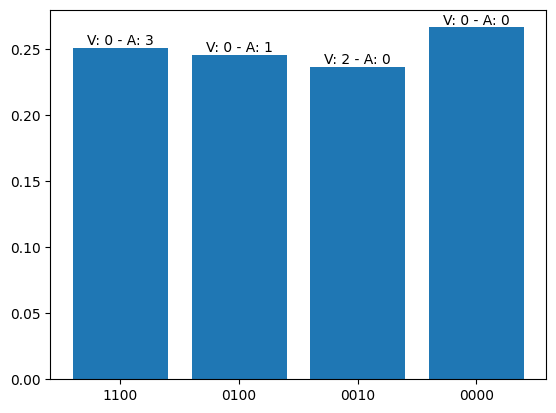

In [44]:
probabilities = [value/results.num_shots for value in results.counts.values()]
labels = [f"V: {label['vertices']:.0f} - A: {label['adjacent_vertices']:.0f}" for label in results.parsed_states.values()] 
values = [key for key in results.counts.keys()]

container = plt.bar(values, probabilities)
plt.bar_label(container, labels)

### Interpretation

>We can observe the $C$ and $S$ operators as blocks in the circuit diagram. The results show a single step of discrete quantum walks where we have chosen a superposition of all the vertices as starting points and the adjacent_vertices register is set to 0. When the current node has an edge with the node described by the adjacent_vertices register, a swap operation is performed.
>
>So, when the vertex is either 1 or 3, it is swapped with the adjacent_vertex as we can see in the bargraph above.

## Linear graph with 16 nodes

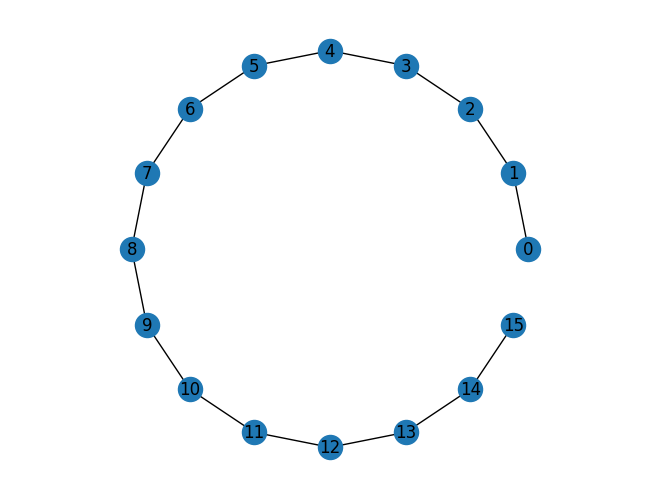

In [45]:
size = 4

edge_list = [(i, i+1) for i in range(2**size-1)]

G = nx.Graph(edge_list)

nx.draw_circular(G, with_labels=True)
plt.axis('equal')
plt.show()

>For the above graph we can make use of the same operators described earlier in this notebook, with a few changes in order to take into consideration its slightly different structure.
>
>The first part (the diffuser) will remain the same as each node has at most two adjacent nodes as in the previous graph.

In [46]:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(aux: QNum,x: QNum):
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

> The $C\_iteration$ function which generates the probabilities for the state preparation will be modified accordingly to the number of vertices and to the graph structure (liniar versus circular): if the node is at the edge of the graph, the probability to return in the adjacent node is $100\%$. Also, because in the previous example we were allocating an ancilla qubit for each zero diffuser and this increased exponentially the number of qubits, here we have reused the same aux qubit allocated only once in the $C\_operator$ function.

In [47]:
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum, aux: QNum):
    prob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if i != 0 and i != 15:
        prob[i+1]=0.5
        prob[i-1]=0.5
    elif i == 0:
        prob[i+1] = 1
    else:
        prob[i-1] = 1
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(aux,adjacent_vertices)))


@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    for i in range(2**size):
      C_iteration(i,vertices,adjacent_vertices,aux)

>The $edge\_oracle$ is also dependent on the type of graph and how it is structured. In order to use as few qubits as possible, we use the fact that two neighbors will always have the difference one. We have to keep track of the direction, so we use a qubit for a step to the left and another one for the right direction.

In [48]:
@qfunc
def edge_oracle(adj_l:Output[QNum],adj_r:Output[QNum], vertices: QNum, adjacent_vertices: QNum):
    adj_l |= ((vertices-adjacent_vertices) ==1)
    adj_r |= ((adjacent_vertices-vertices) ==1)


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    adj_l = QNum('adj_l')
    adj_r = QNum('adj_r')
    edge_oracle(adj_l,adj_r,vertices,adjacent_vertices)
    control(ctrl= adj_l==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))
    control(ctrl= adj_r==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

>The last step is to create the whole circuit, allocating the qubits for vertices and for adjacent_vertices, to put in a superposition the starting position and to apply the $SC$ operators described above. In order to have a minimum width, we are optimizing the circuit with the $\textcolor{#D7F75B}{Classiq's}$ synthesizer's help.

In [49]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  C_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
quantum_model_with_constraints = set_constraints(
    qmod, Constraints(optimization_parameter="width", max_depth=10000)
)
qprog = synthesize(quantum_model_with_constraints)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

<img src="Liniar16.jpg" width="100%">

In [51]:
results = execute(qprog).result()[0].value 

[Text(0, 0, 'V: 15 - A: 0'),
 Text(0, 0, 'V: 14 - A: 0'),
 Text(0, 0, 'V: 4 - A: 0'),
 Text(0, 0, 'V: 0 - A: 1'),
 Text(0, 0, 'V: 10 - A: 0'),
 Text(0, 0, 'V: 12 - A: 0'),
 Text(0, 0, 'V: 8 - A: 0'),
 Text(0, 0, 'V: 6 - A: 0'),
 Text(0, 0, 'V: 13 - A: 0'),
 Text(0, 0, 'V: 0 - A: 0'),
 Text(0, 0, 'V: 2 - A: 0'),
 Text(0, 0, 'V: 11 - A: 0'),
 Text(0, 0, 'V: 3 - A: 0'),
 Text(0, 0, 'V: 7 - A: 0'),
 Text(0, 0, 'V: 9 - A: 0'),
 Text(0, 0, 'V: 5 - A: 0')]

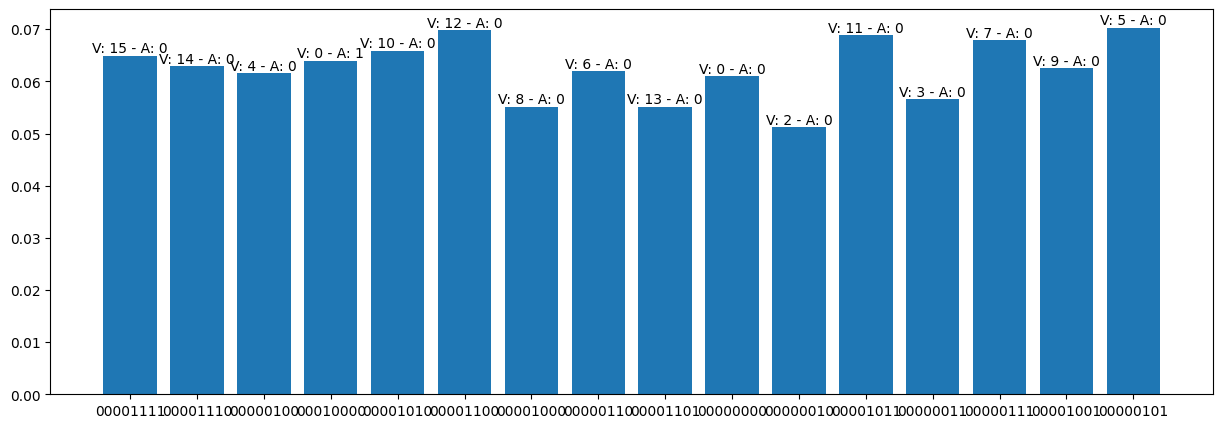

In [66]:
probabilities = [value/results.num_shots for value in results.counts.values()]
labels = [f"V: {label['vertices']:.0f} - A: {label['adjacent_vertices']:.0f}" for label in results.parsed_states.values()] 
values = [key for key in results.counts.keys()]
plt.figure(figsize=(15, 5))
container = plt.bar(values, probabilities)
plt.bar_label(container, labels)

>We can observe that the final optimized cirtuit has a depth of $11$, just two more qubits above the earlier example because of some optimization techniques.
>
>The results show that for the starting node 1 and the adjacent_vertices register set to 0, the current node will be swapped with the adjacent node, so the walker takes a step in this direction. 

# Thank you!